In [1]:
import numpy as np
import pandas as pd
from formatting_data import get_data_frame
from functions import draw_x_gametimes, cost, draw_history,draw_log_history

In [2]:
df, game_df = get_data_frame(50000) #game_df used for identifying game using game_id
df.head(3)

,user_id,game_id,playtime
0,0,11,6119.0
1,0,21,47.0
2,0,23,29480.0


In [27]:
df

,user_id,game_id,playtime
0,0,11,6119.0
1,0,21,47.0
2,0,23,29480.0
3,0,115,63967.0
4,0,132,8030.0
...,...,...,...
49995,501,4246,0.0
49996,501,4247,0.0
49997,501,4291,640.0
49998,501,4385,21.0


In [24]:
user0 = df.loc[df.user_id == 0].sort_values(by='playtime', ascending=False).head(10)[['game_id', 'playtime']]
user0_games = game_df.set_index(game_df.game_id).loc[user0.game_id, 'game_name']
user0_playtimes = user0[['game_id', 'playtime']]

In [25]:
top10 = pd.merge(user0_games, user0_playtimes, on=['game_id'])

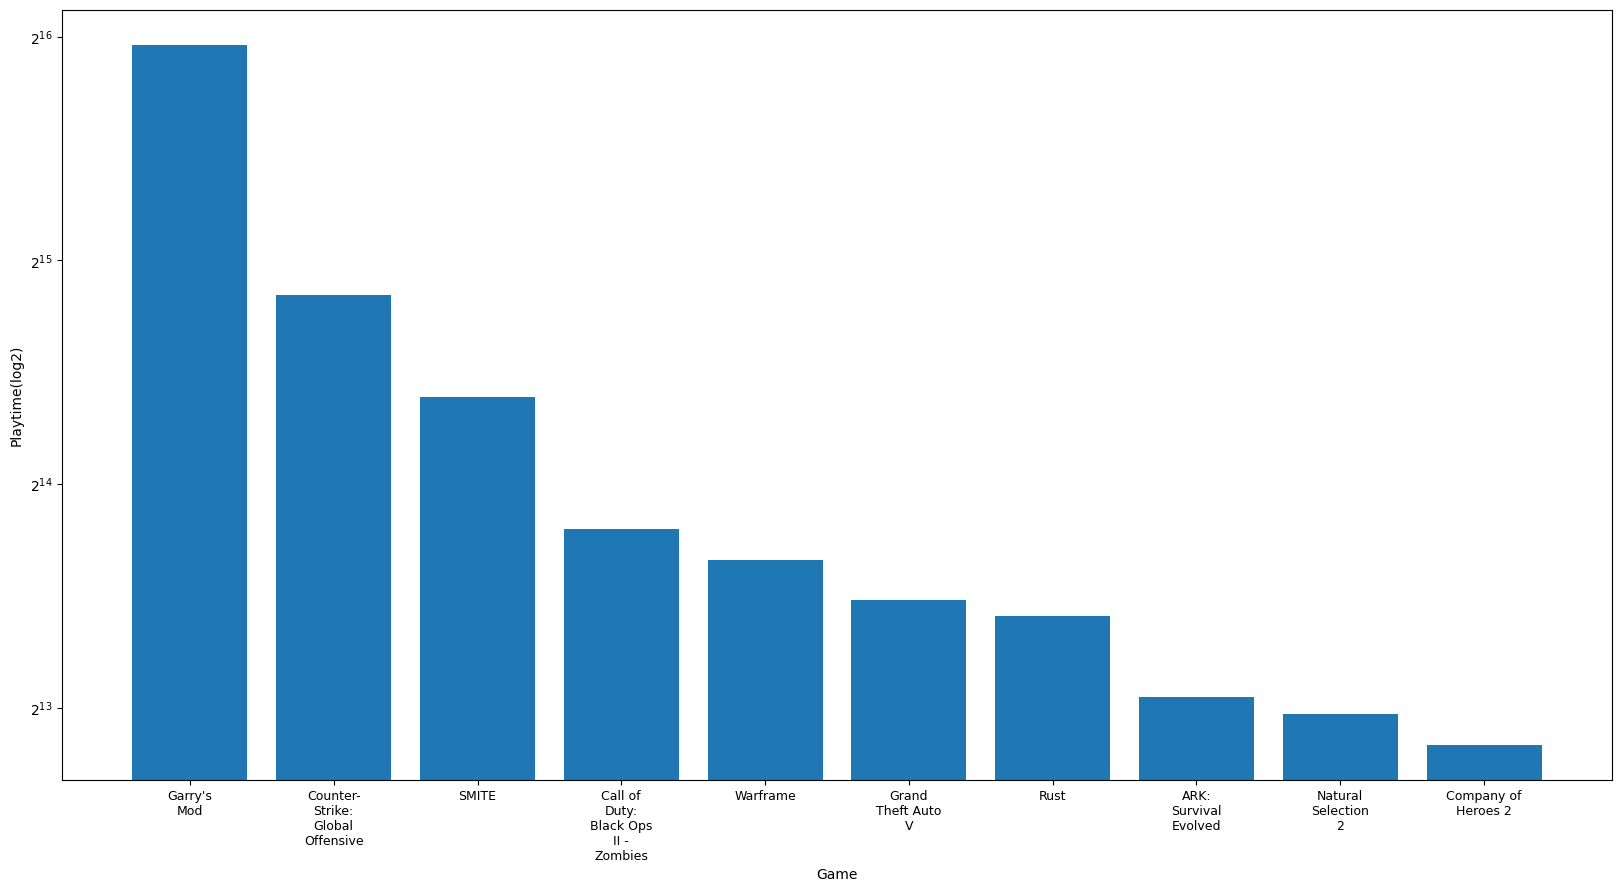

In [26]:
draw_x_gametimes(top10)

In [6]:
#creating utility matrix
utility_matrix = df.pivot_table(index=df.columns[0], columns=df.columns[1], values=df.columns[2], fill_value=0)
utility_matrix = utility_matrix.to_numpy(dtype=np.float32)

In [7]:
#R matrix for checking if the player has played the game
R = (utility_matrix != 0).astype(int)

In [8]:
num_features = 20
np.random.seed(9)

#initialising users and items features randomly
user_matrix = np.random.uniform(0,1,(utility_matrix.shape[0], num_features))
item_matrix = np.random.uniform(0,1,(utility_matrix.shape[1], num_features))
user_matrix = np.float32(user_matrix)
item_matrix = np.float32(item_matrix)

In [9]:
pred = user_matrix @ item_matrix.T
cost(utility_matrix, pred, R)

1399876383469.9646

In [10]:
alpha = 0.0000001
lambda_ = 0.1

In [11]:
history = []
iterations = 2000

for i in range(iterations):
    pred = user_matrix @ item_matrix.T
    error = (utility_matrix - pred * R)

    item_slope = error.T @ user_matrix
    item_slope *= alpha

    user_slope = error @ item_matrix
    user_slope *= alpha

    user_matrix += user_slope
    item_matrix += item_slope

    if(i % (iterations // 20) == 0):
        current_cost = cost(utility_matrix, user_matrix @ item_matrix.T, R)
        history.append(current_cost)
    if i % (iterations // 10) == 0:
        print(f'iteration:{i}, cost:{current_cost}')

iteration:0, cost:1399770981441.152
iteration:200, cost:376716681176.87866
iteration:400, cost:170773432372.17877
iteration:600, cost:77179701465.11922
iteration:800, cost:45588817299.564095
iteration:1000, cost:31856563983.870617
iteration:1200, cost:24439502443.471027
iteration:1400, cost:19794160193.34661
iteration:1600, cost:16660975157.213593
iteration:1800, cost:14437238402.60733


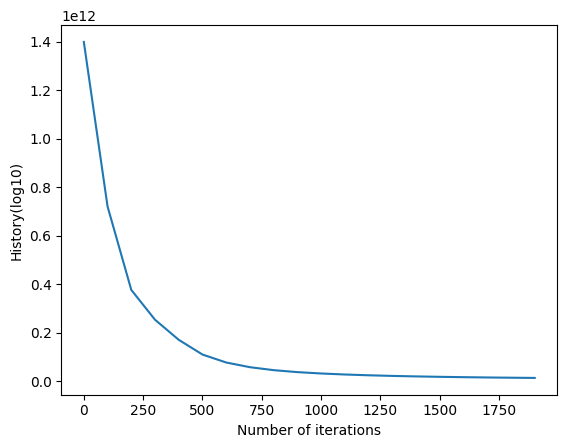

In [12]:
draw_history(range(0, iterations, iterations//20), history)

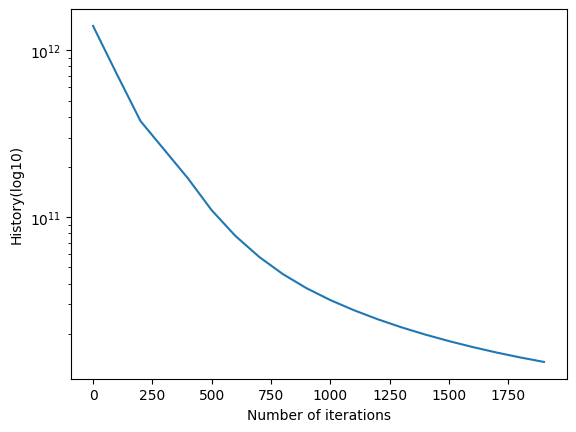

In [13]:
draw_log_history(range(0, iterations, iterations//20), history)

In [17]:
user = 1
top20 = np.sort(pred[user])[-20:]
top20i = np.where(np.isin(pred[user], top20))

In [18]:
time_df = pd.DataFrame({'game_id': np.array(top20i).flatten(), 'predicted_playtime': pred[user,top20i].flatten()})
top20_df = pd.merge(game_df.iloc[top20i], time_df, on=['game_id'])
top20_df = top20_df.sort_values(ascending=False, by=['predicted_playtime'])
top20_df = top20_df.reset_index(drop=True)

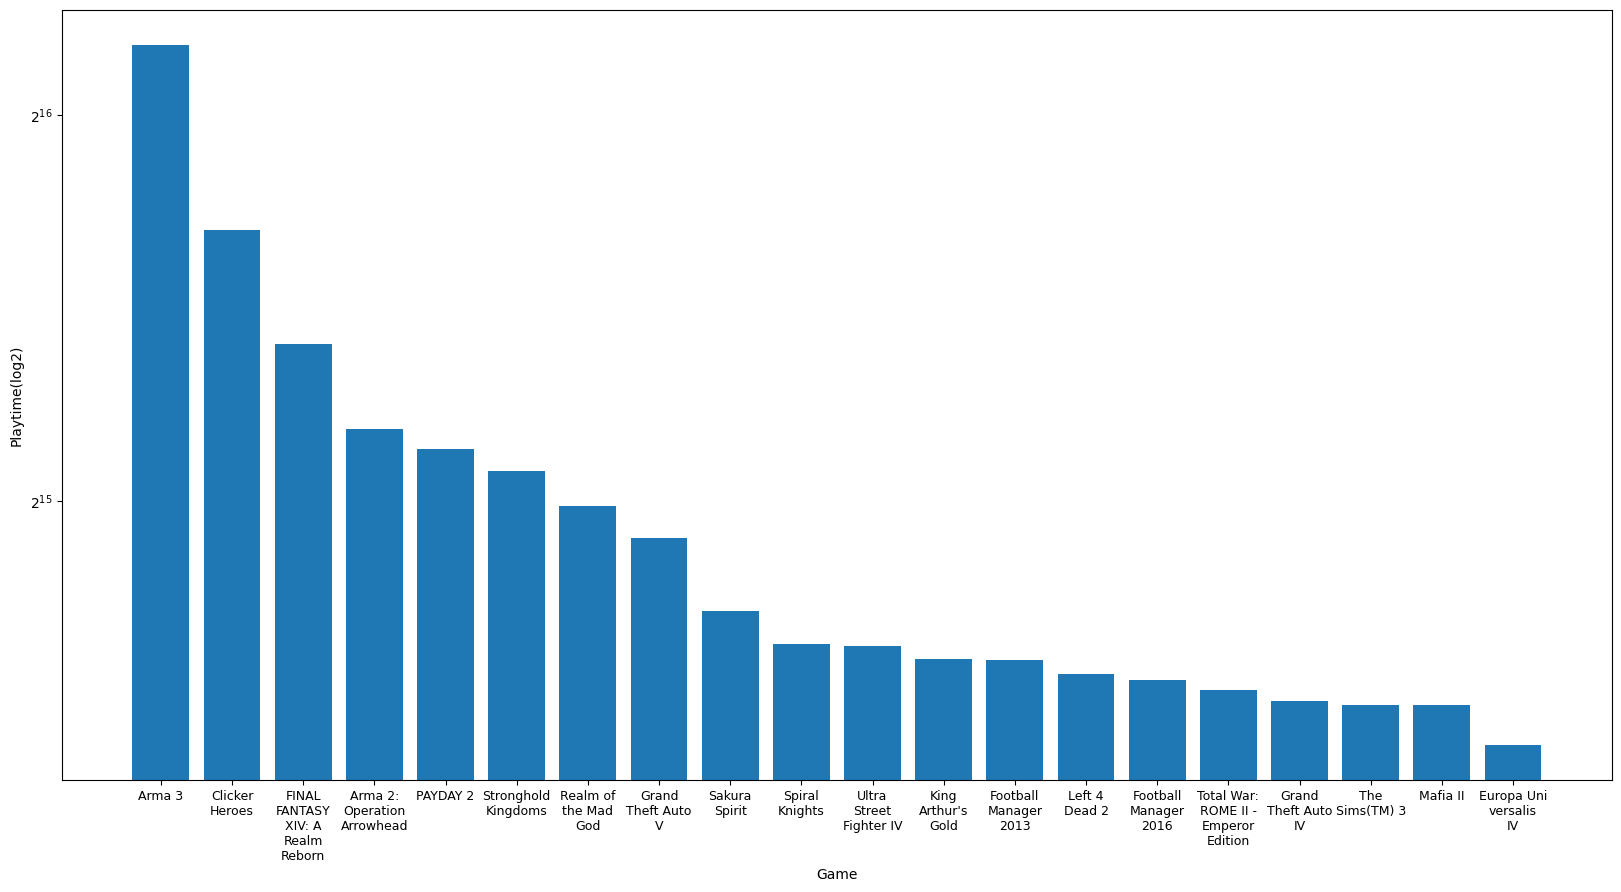

In [19]:
draw_x_gametimes(top20_df)